<a href="https://colab.research.google.com/github/Shivesh2001/Darts_RNN/blob/main/Darts_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks for Time Series Forecasting: LTSM, GRU, Vanilla
## wrapped by the Darts multi-method package for time series analysis

In [ ]:
EPOCH = 5        # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel, RNNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 1080               # forecast periods
# FC_STRIDE = 10
FC_START = "2016-12-31 20:00:00"   # period at which to split training and validation dataset


# Prepare the Source Data

In [ ]:
# Load and preprocess the dataset
df = pd.read_excel("/content/86_13_.xlsx")

print(len(df))
print(df.columns)

26298
Index(['longitude', 'latitude', 'time', 'u100', 'v100', 'u10n', 'u10', 'v10n',
       'v10', 'msl', 'mwp', 'sst', 'swh', 'sp'],
      dtype='object')


In [ ]:
df = df.loc[ :, ['time', 'u100', 'v100', 'u10n', 'u10', 'v10n',
       'v10', 'msl', 'sst', 'sp', 'mwp', 'swh']]

df = df.set_index('time')
ts = TimeSeries.from_series(df['swh'])

In [ ]:
# ts = AirPassengersDataset().load()

In [ ]:
series = ts  
Data = ts.pd_dataframe()
Data

component,swh
time,
2007-01-01 00:00:00,1.103332
2007-01-01 04:00:00,1.115466
2007-01-01 08:00:00,1.122928
2007-01-01 12:00:00,1.003857
2007-01-01 16:00:00,0.998536
...,...
2018-12-31 04:00:00,1.342506
2018-12-31 08:00:00,1.259356
2018-12-31 12:00:00,1.277904


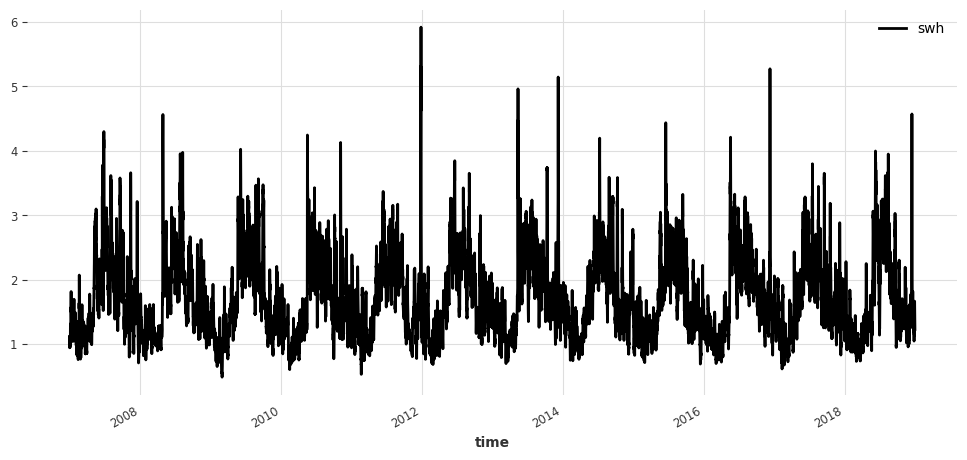

In [ ]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [ ]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 54.0
periodicity (~years) : 4.5


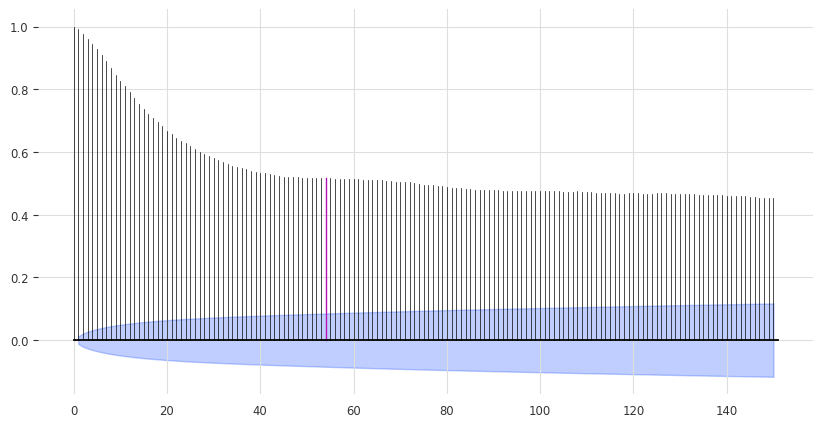

In [ ]:
# plot its autocorrelation function
plot_acf(ts, periodicity, max_lag=150)

In [ ]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [ ]:
train, val

(<TimeSeries (DataArray) (time: 21918, component: 1, sample: 1)>
 array([[[1.10333157]],
 
        [[1.11546576]],
 
        [[1.12292802]],
 
        ...,
 
        [[1.38079143]],
 
        [[1.47202671]],
 
        [[1.49699557]]])
 Coordinates:
   * time       (time) datetime64[ns] 2007-01-01 ... 2016-12-31T20:00:00
   * component  (component) object 'swh'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (time: 4380, component: 1, sample: 1)>
 array([[[1.46592319]],
 
        [[1.5220437 ]],
 
        [[1.58854795]],
 
        ...,
 
        [[1.27790391]],
 
        [[1.27425766]],
 
        [[1.22598457]]])
 Coordinates:
   * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T20:00:00
   * component  (component) object 'swh'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None)

In [ ]:
# normalize the time series
trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)

# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [ ]:
features = ['u100', 'v100']
past_cov = TimeSeries.from_dataframe(df[features])

cov_train, cov_val = past_cov.split_after(pd.Timestamp(FC_START))

# Run the RNN Models

In [ ]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start = time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(series=train,
             past_covariates=past_cov,
             val_series=val,
             val_past_covariates=past_cov,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [ ]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = BlockRNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        batch_size=32,
        hidden_dim=20,
        input_chunk_length=FC_N,
        output_chunk_length=1,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    res = fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, past_covariates=past_cov) 

    return pred
    

In [ ]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(20,12))
    act[21918:21918+FC_N].plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()

In [ ]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)     # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "R squared":res_r2, "se": res_sefc}
    return res_accuracy

R2 score: 0.60408324921102
Mean squared error: 0.004564243239622868


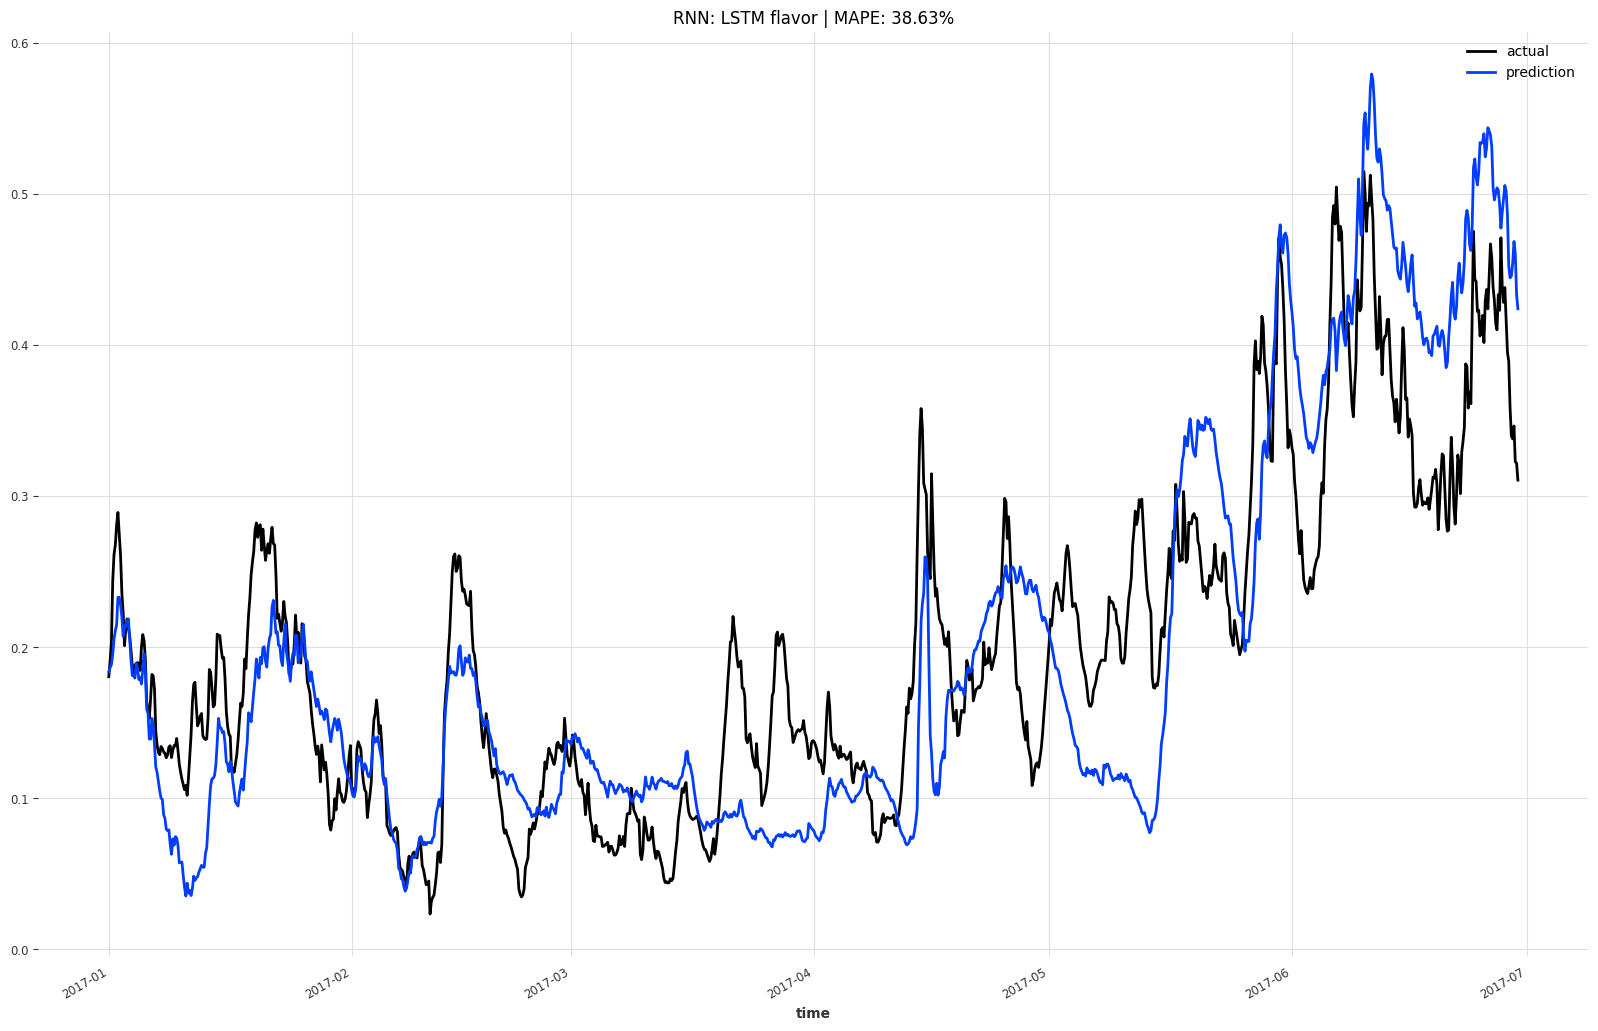

In [ ]:
# run 3 different flavors of RNN on the time series:
# flavors = ["LSTM", "GRU", "RNN"]

pred_LSTM = run_RNN("LSTM", ts_trf, train_trf, val_trf)

# plot predictions vs actual
plot_fitted(pred_LSTM, ts_trf, "LSTM")

# # print accuracy metrics
# LSTM_acc = accuracy_metrics(pred_LSTM, ts_trf)    
# print("LSTM" + " : ")
# _ = [print(k,":",f'{v:.4f}') for k,v in LSTM_acc.items()]

# Computing the coefficient of determination (R2 score) to evaluate the model
r2 = r2_score(ts_trf.values()[21918:21918+FC_N], pred_LSTM.values())
print('R2 score:', r2)

# Evaluating the model using mean squared error metric
mse = mean_squared_error(ts_trf.values()[21918:21918+FC_N], pred_LSTM.values())
print(f"Mean squared error: {mse}")

In [ ]:
train_trf

<TimeSeries (DataArray) (time: 21918, component: 1, sample: 1)>
array([[[0.11380454]],

       [[0.11603647]],

       [[0.11740906]],

       ...,

       [[0.16483966]],

       [[0.1816212 ]],

       [[0.18621389]]])
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 ... 2016-12-31T20:00:00
  * component  (component) object 'swh'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# pred_GRU = run_RNN("GRU", ts_trf, train_trf, val_trf)

# # plot predictions vs actual
# plot_fitted(pred_GRU, ts_trf, "GRU")

# # # print accuracy metrics
# # GRU_acc = accuracy_metrics(pred_GRU, ts)    
# # print("GRU" + " : ")
# # _ = [print(k,":",f'{v:.4f}') for k,v in GRU_acc.items()]

# # Computing the coefficient of determination (R2 score) to evaluate the model
# r2 = r2_score(ts_trf.values()[21918:21918+1080], pred_GRU.values())
# print('R2 score:', r2)

# # Evaluating the model using mean squared error metric
# mse = mean_squared_error(ts_trf.values()[21918:21918+1080], pred_GRU.values())
# print(f"Mean squared error: {mse}")

R2 score: 0.4475902565431671
Mean squared error: 0.00636833988976258


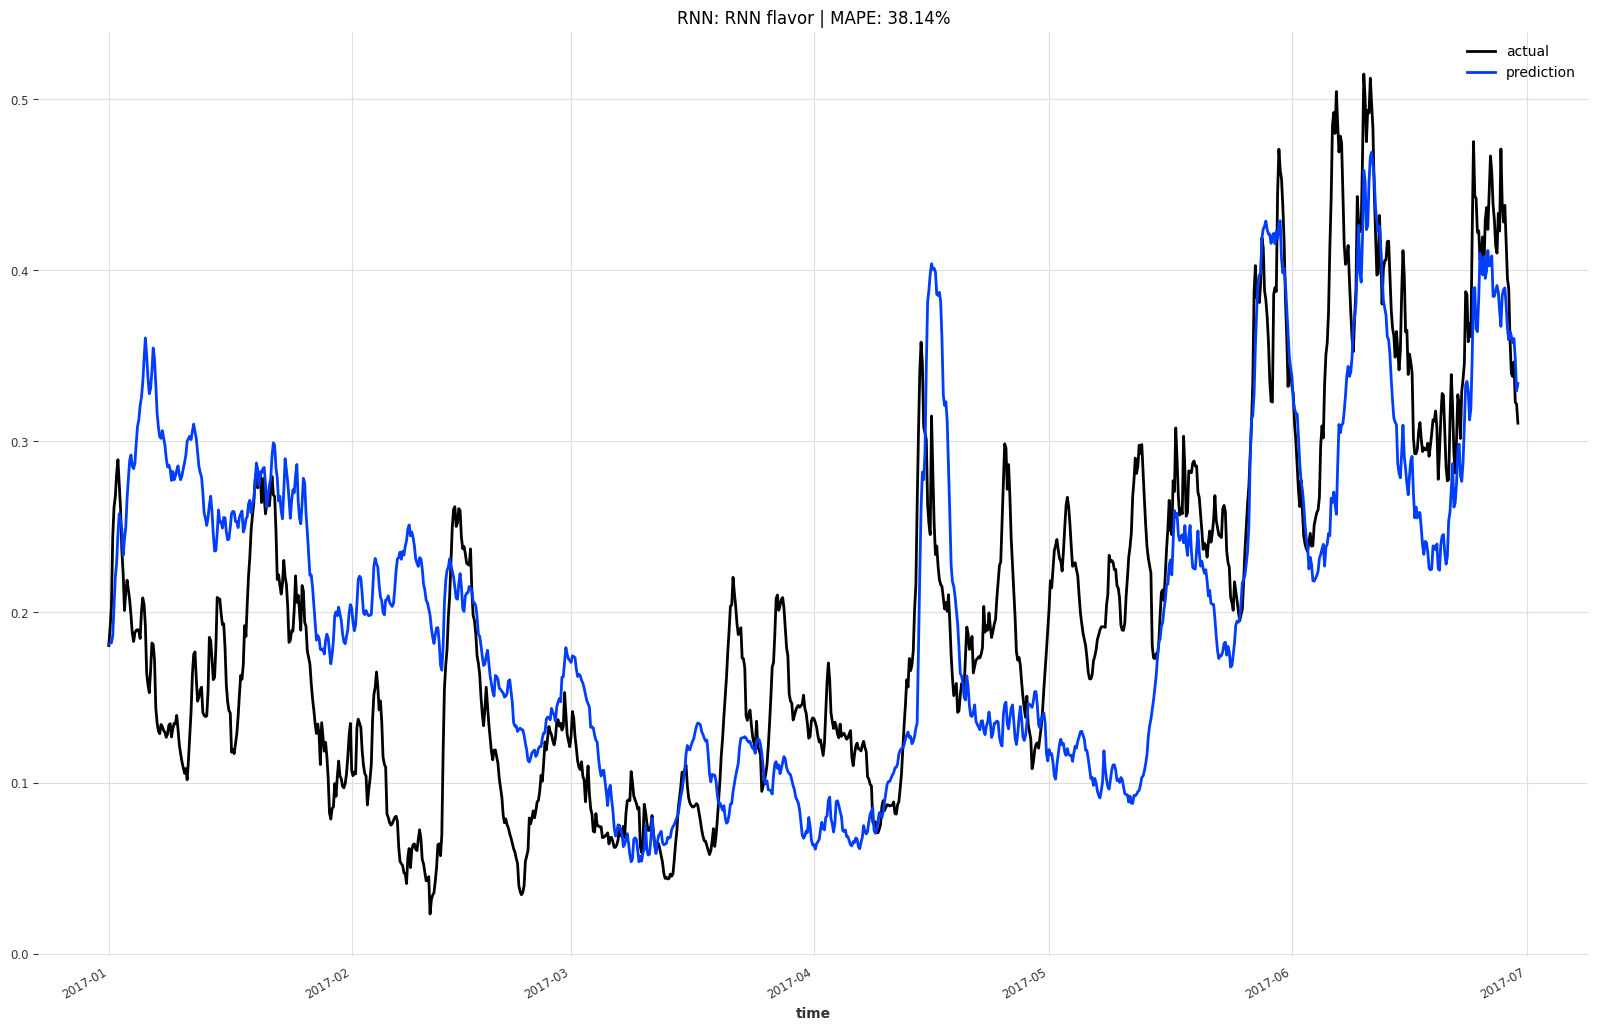

In [34]:
pred_Vanilla = run_RNN("RNN", ts_trf, train_trf, val_trf)

# plot predictions vs actual
plot_fitted(pred_Vanilla, ts_trf, "RNN")

# # print accuracy metrics
# Vanilla_acc = accuracy_metrics(pred_Vanilla, ts)    
# print("RNN" + " : ")
# _ = [print(k,":",f'{v:.4f}') for k,v in Vanilla_acc.items()]

# Computing the coefficient of determination (R2 score) to evaluate the model
r2 = r2_score(ts_trf.values()[21918:21918+FC_N], pred_Vanilla.values())
print('R2 score:', r2)

# Evaluating the model using mean squared error metric
mse = mean_squared_error(ts_trf.values()[21918:21918+FC_N], pred_Vanilla.values())
print(f"Mean squared error: {mse}")

# Compare with the Theta method

In [ ]:
# # Theta forecaster

# # search space for best theta value: check 100 alternatives
# thetas = 2 - np.linspace(-10, 10, 100)

# # initialize search
# best_mape = float('inf')
# best_theta = 0
# t_start =  time.perf_counter()
# # search for best theta among 100 values, as measured by MAPE
# for theta in thetas:
#     model = Theta(theta)
#     res = model.fit(train)
#     pred_theta = model.predict(len(val))
#     res_mape = mape(val, pred_theta)
#     if res_mape < best_mape:
#         best_mape = res_mape
#         best_theta = theta


# # fit the model
# best_theta_model = Theta(best_theta)
# best_theta_model.fit(train)
# pred = best_theta_model.predict(len(val))

# # review the Theta results
# plt.figure(figsize=(12,5))
# train.plot(label='actual: training set')
# val.plot(label='actual: validation set')
# pred.plot(label='Theta predictions')
# plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
# plt.legend();

# res_time = time.perf_counter() - t_start
# res_acc = accuracy_metrics(pred, val)
# print("Theta forecast has completed: ", f'{res_time:.2f} sec')
# _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
# results = [pred, res_acc]


In [ ]:
# # collect the forecasters's accuracy metrics in a dataframe

# dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
#     "Vanilla":res_flavors[2][1]}
# df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
# pd.set_option("display.precision",3)
# df_acc.style.highlight_min(color="black", axis=1).highlight_max(color="grey", axis=1)